# Transfer Function Modeling (without initial guess)

Text(0.5, 0, 'Frequency (Hz)')

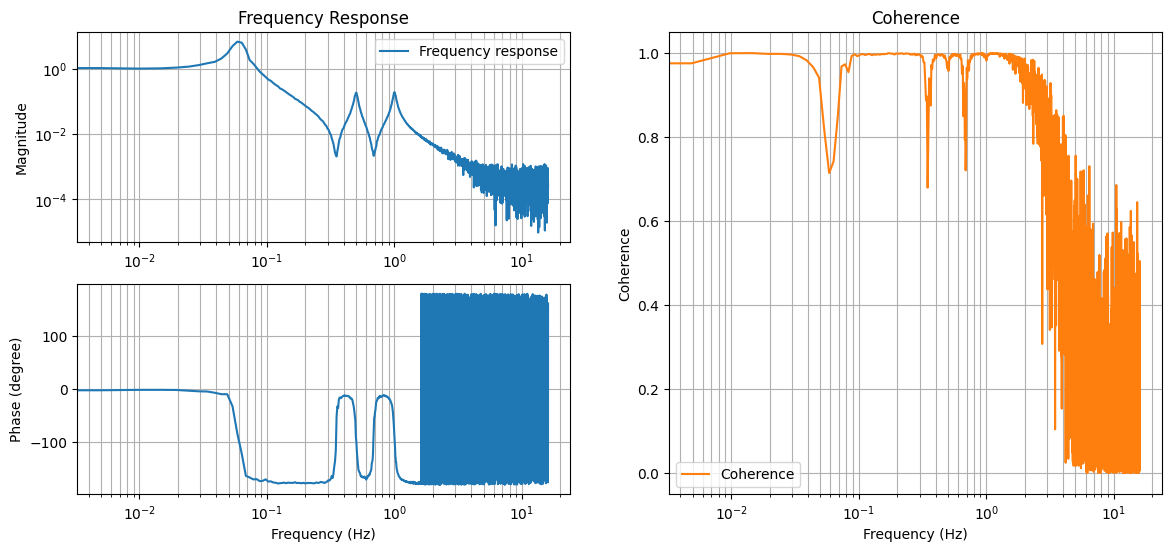

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol

# Define the transfer function (We don't know this yet!)
# This is the transfer function we defined for x1 in sensor matrix diagonalization tutorial.
s = control.tf("s")
fs = 32
t = np.linspace(0, 1024, 1024*fs)

w1 = 0.06*2*np.pi
w4 = 0.5*2*np.pi
w5 = 1*2*np.pi
q1 = 10
q4 = 20
q5 = 20
tf1 = w1**2 / (s**2+w1/q1*s+w1**2)
tf4 = 0.01*w4**2 / (s**2+w4/q4*s+w4**2)
tf5 = 0.01*w5**2 / (s**2+w5/q5*s+w5**2)

tf = tf1 + tf4 + tf5

# For the sake of reproducibility
np.random.seed(123)

# Unit white noise injection
u = np.random.normal(loc=0, scale=1/np.sqrt(fs), size=len(t))

# Measure the output
_, y, = control.forced_response(tf, U=u, T=t)

# Let's add some measurement noise
y += np.random.normal(loc=0, scale=1e-3/np.sqrt(fs), size=len(t))

# Obtain the frequency response
f, p_uy = scipy.signal.csd(u, y, fs=fs, nperseg=int(len(t)/5))
_, p_uu = scipy.signal.welch(u, fs=fs, nperseg=int(len(t)/5))
_, p_yy = scipy.signal.welch(y, fs=fs, nperseg=int(len(t)/5))

frequency_response = p_uy/p_uu
coherence = abs(p_uy)**2/p_uu/p_yy

plt.figure(figsize=(14, 6))
plt.subplot(221)
plt.title("Frequency Response")
plt.loglog(f, abs(frequency_response), label="Frequency response")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
# plt.xlabel("Frequency (Hz)")

plt.subplot(223)
plt.semilogx(f, 180/np.pi*np.angle(frequency_response))
# plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (Hz)")

plt.subplot(122)
plt.title("Coherence")
plt.semilogx(f, coherence, color="C1", label="Coherence")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Coherence")
plt.xlabel("Frequency (Hz)")
# ^Here's what we measured

In [2]:
# Data at frequency above ~2 Hz is plagued with noise, let's filter them out.
# Data at ~0.32 and ~0.65 Hz have low coherence. But that doesn't mean we should
# filter them out.
# The low coherence was due to the presences of the complex zeros in the transfer function,
# which is a characteristic of the system we're trying to moddel.
# And we wanna get rid of the 0 frequency data point.
frequency_response_fit = frequency_response[(f>0)*(f<2)]
f_fit = f[(f>0)*(f<2)]

In [3]:
# Seed the random seed
np.random.seed(2)  # For education purposes, try other values yourself.

# To use a curvefit instance, we need to define several attributes,
# xdata, ydata, model, cost, and optimizer (and optionally optimizer_kwargs, ...).
# The kontrol.curvefit.TransferFunctionFit class has predefined cost and optimizer.
# However, if we want to obtain a fit without an initial guess, we have to define a
# global optimizer (differential_evolution in this case).
curvefit = kontrol.curvefit.TransferFunctionFit()
curvefit.xdata = f_fit
curvefit.ydata = frequency_response_fit

# To use a ComplexZPK instance, we need to specify the number of complex zeros pairs and
# number of complex pole pairs.
# From the frequency response data, we see 2 notches and 3 peaks, which correspond to 
# 2 complex zero pairs and 3 complex pole pairs.
# The roll-off at high frequency is 2 orders of magnitude per decade, which means
# there're 2 more poles than zeros. The analysis above agrees with this observation.
# Here, log_args=True means that we're scaling the parameters logrithmically, 
# which is useful because we know the poles and zeros span across different magnitude in frequency.
curvefit.model = kontrol.curvefit.model.ComplexZPK(nzero_pairs=2, npole_pairs=3, log_args=True)

# Optimizer
curvefit.optimizer = scipy.optimize.differential_evolution

# Boundary for the arguments.
# The model parameters is arranged in a list as [f1, q1, f2, q2, ... k],
# where f1, and q1 is the frequency and Q factor of the zeros/poles, and k is the static gain.
# The bounds for the frequency is easy. We can simply define it as the min and max of the
# frequency data we obtained in the frequency response.
# The Q value denotes the height or depth of the peak or depth.
# For complex zero/pole pairs, it cannot be lower than 0.5. 
# And, from the frequency response plot, the height doesn't seem to be higher than
# 2 orders of magnitude.
# Setting the upper bound to 1e3 seems reasonable.
# As for the static gain, the magnitude at low frequency is close to 1e0.
# Setting the bound between 1e-1 and 1e1 seems reasonable.

# For frequency and Q factor
# Remeber we're fitting in log scale
bounds = [(np.log10(min(f_fit)), np.log10(max(f_fit))), (np.log10(0.5), np.log10(1e3))]
bounds *= 2+3  # Number of complex zeros pairs and number of complex pole pairs

# For the gain
bound_gain = (np.log10(1e-1), np.log10(1e1))

# Finally,
bounds.append(bound_gain)

# optimizer kwargs
curvefit.optimizer_kwargs = {"bounds": bounds}

# Fit
results = curvefit.fit()

Text(0.5, 0, 'Frequency (Hz)')

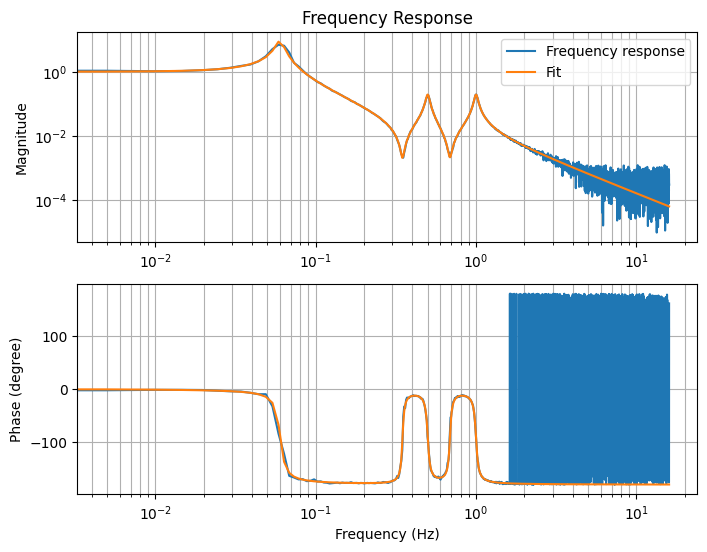

In [4]:
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.title("Frequency Response")
plt.loglog(f, abs(frequency_response), label="Frequency response")
plt.loglog(f, abs(curvefit.model(f, args=results.x)), label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
# plt.xlabel("Frequency (Hz)")

plt.subplot(212)
plt.semilogx(f, 180/np.pi*np.angle(frequency_response))
plt.semilogx(f, 180/np.pi*np.angle(curvefit.model(f, args=results.x)))
# plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (Hz)")

In [5]:
# Let's inspect the fitted transfer function
print("True transfer function:\n", tf)
print("Fitted transfer function:\n", curvefit.model.tf.minreal())

True transfer function:
 
       0.6356 s^4 + 0.1786 s^3 + 14.89 s^2 + 1.629 s + 56.48
--------------------------------------------------------------------
s^6 + 0.5089 s^5 + 49.56 s^4 + 11.23 s^3 + 397 s^2 + 16.01 s + 55.38

Fitted transfer function:
 
        0.636 s^4 + 0.1785 s^3 + 14.91 s^2 + 1.626 s + 56.65
---------------------------------------------------------------------
s^6 + 0.5179 s^5 + 49.55 s^4 + 11.48 s^3 + 396.7 s^2 + 17.01 s + 55.2



In [6]:
# ^Close enough!
# Let's export the transfer function for future purposes.
curvefit.model.tf.save("transfer_function_x1_without_guess.pkl")

In [7]:
# Alternatively, export the Foton string and install it to the digital system
curvefit.model.tf.foton(root_location="n")

'zpk([0.006973+i*0.347667;0.006973+i*-0.347667;0.015365+i*0.687354;0.015365+i*-0.687354],[0.003204+i*0.059844;0.003204+i*-0.059844;0.012652+i*0.499616;0.012652+i*-0.499616;0.025355+i*0.999705;0.025355+i*-0.999705],1.02636,"n")'